# EXERCISE 2 - ML - Grundverfahren

Denis Blessing: denis.blessing@kit.edu. This homework has 4 topics with 19 points in total.

## Submission Instructions
Please follow the instruction from homework ZERO!

## 1.) Multiclass Classification (7p)

The Iris Dataset is a very classical machine learning and statistics benchmark for classification, developed in the 1930's. The goal is to classify 3 types of flowers (more specifically, 3 types of flowers form the Iris species) based on 4 features: petal length, petal width, sepal length and sepal width.

As we have $K=3$ different types of flowers we are dealing with a multi-class classification problem and need to extend our sigmoid-based classifier from the previous exercise / recap session.

We will reuse our "minimize" and "affine feature" functions. Those are exactly as before. The affine features are sufficient here.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings
from typing import Callable, Tuple

warnings.filterwarnings('ignore')

def minimize(f: Callable , df: Callable, x0: np.ndarray, lr: float, num_iters: int) -> \
        Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """
    :param f: objective function
    :param df: gradient of objective function
    :param x0: start point, shape [dimension]
    :param lr: learning rate
    :param num_iters: maximum number of iterations
    :return argmin, min, values of x for all interations, value of f(x) for all iterations
    """
    # initialize
    x = np.zeros([num_iters + 1] + list(x0.shape))
    f_x = np.zeros(num_iters + 1)
    x[0] = x0
    f_x[0] = f(x0)
    for i in range(num_iters):
        # update using gradient descent rule
        grad = df(x[i])
        x[i + 1] = x[i] - lr * grad
        f_x[i + 1] = f(x[i + 1])
    return x[i+1], f_x[i+1], x[:i+1], f_x[:i+1] # logging info for visualization


def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs
    :return inputs with additional bias dimension
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

### Load and Prepare Data
In the original dataset the different types of flowers are labeled with $0, 1$ and $2$. The output of our classifier will be a vector with $K=3$ entries, $\begin{pmatrix}p(c=0 | \boldsymbol x) & p(c=1 | \boldsymbol x) & p(c=2 | \boldsymbol x) \end{pmatrix}$, i.e. the probability for each class that a given sample is an instance of that class, given a datapoint $\boldsymbol x$. As presented in the lecture, working with categorical (=multinomial) distributions is easiest when we represent the labels in a different form, a so called one-hot encoding. This is a vector of the length of number of classes, in this case 3, with zeros everywhere except for the entry corresponding to the class number, which is one. For the train and test data we know to which class it belongs, so the probability for that class is one and the probability for all other classes zero.

In [2]:
data = np.load("iris_data.npz")
train_samples = data["train_features"]
train_labels = data["train_labels"]
test_samples = data["test_features"]
test_labels = data["test_labels"]

train_features = affine_features(train_samples)
test_features = affine_features(test_samples)

def generate_one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    :param y: vector containing classes as numbers, shape: [N]
    :param num_classes: number of classes
    :return a matrix containing the labels in an one-hot encoding, shape: [N x K]
    """
    y_oh = np.zeros([y.shape[0], num_classes])

    # can be done more efficiently using numpy with
    # y_oh[np.arange(y.size), y] = 1.0
    # we use the for loop for clarity

    for i in range(y.shape[0]):
        y_oh[i, y[i]] = 1.0

    return y_oh


oh_train_labels = generate_one_hot_encoding(train_labels, 3)
oh_test_labels = generate_one_hot_encoding(test_labels, 3)

### Optimization using Gradient Descent

The multi-class generalization of the sigmoid is the softmax function. It takes an vector of length $K$ and outputs another vector of length $K$ where the $k$-th entry is given by
$$ \textrm{softmax}(\boldsymbol{x})_k = \dfrac{\exp(x_k)}{\sum_{j=1}^K \exp(x_j)}.$$
This vector contains positive elements which sum to $1$ and thus can be interpreted as parameters of a categorical distribution. Lets see how we can implement it

In [3]:
def softmax(x: np.ndarray) -> np.ndarray:
    """softmax function
    :param x: inputs, shape: [N x K]
    :return softmax(x), shape [N x K]
    """
    a = np.max(x, axis=-1, keepdims=True)
    log_normalizer = a + np.log(np.sum(np.exp(x - a), axis=-1, keepdims=True))
    return np.exp(x - log_normalizer)

**Practical Aspect:** In the above implementation of the softmax we stayed in the log-domain until the very last command.
We also used the log-sum-exp-trick (https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).
Staying in the log domain and applying the log-sum-exp-trick whenever possible is a simple way to make the implementation
numerically more robust. It does not change anything with regards to the underlying theory.

We also need to extend our loss function. Instead of the log-likelihood of a Bernoulli distribution, we now maximize the log-likelihood of a categorical distribution which, for a single sample $\boldsymbol{x}_i$, is given by
$$\log p(c_i | \boldsymbol x_i) = \sum_{k=1}^K h_{i, k} \log(p_{i,k})$$
where $\boldsymbol h_i$ denotes the one-hot encoded true label and $p_{i,k} \equiv p(c_i = k | \boldsymbol x_i)$ the class probabilities predicted by the classifier. In multiclass classification, we learn one weight vector $\boldsymbol w_k$ per class s.t. those probabilities are given by $p(c_i = k | \boldsymbol x_i) = \mathrm{softmax}(\boldsymbol w^T \boldsymbol \phi (\boldsymbol x_i))_k $.
We can now implement the (negative) log-likelihood of a categorical distribution (we use the negative log-likelihood as we will minimize the loss later on).

In [4]:
def categorical_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    cross entropy loss function
    :param predictions: class labels predicted by the classifier, shape: [N x K]
    :param labels: true class labels, shape: [N x K]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions, shape: [N]
    """
    return - np.sum(labels * np.log(predictions + epsilon), -1)


This gives us the loss for a single sample. To get the loss for all samples we will need to sum over loss for a single sample

\begin{align}
\mathcal L_{\mathrm{cat-NLL}}
=& - \sum_{i=1}^N \log p(c_i | \boldsymbol x_i) \\
=& - \sum_{i=1}^N \sum_{k=1}^K h_{i, k} \log(p_{i,k}) \\
=& - \sum_{i=1}^N  \sum_{k=1}^K h_{i, k} \log(\textrm{softmax}(\boldsymbol{w}_k^T \boldsymbol \phi(\boldsymbol{x}_i))_k)\\
=& - \sum_{i=1}^N \left(\sum_{k=1}^K h_{i,k}\boldsymbol{w}^T_k \boldsymbol \phi(\boldsymbol{x}_i) - \log \sum_{j=1}^K \exp(\boldsymbol{w}_j^T \boldsymbol \phi(\boldsymbol{x}_i))\right).
\end{align}

In order to use gradient based optimization for this, we of course also need to derive the gradient.



### Exercise 1.1) Derivation (4 Points)
Derive the gradient $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}}$ of the loss function w.r.t. the full weight vector $\boldsymbol w \equiv \begin{pmatrix} \boldsymbol w_1^T & \dots & \boldsymbol w_K^T \end{pmatrix}^T$, which is obtained by stacking the class-specific weight vectors $\boldsymbol w_k$.

**Hint 1:** Follow the steps in the derivation of the gradient of the loss for the binary classification in the lecture.

**Hint 2:** Derive the gradient not for the whole vector $\boldsymbol w$ but only for $\boldsymbol w_k$, i.e., $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}_k}$. The gradients for the individual
$\boldsymbol w_k$ can then be stacked to obtain the full gradient.

**Answer:**

![](ex1.1.png)

### Exercise 1.2) Implementation (3 Points)
Now that we have the formulas for the loss and its gradient, we can implement them. Fill in the function skeletons below so that they implement the loss and its gradient. Again, in praxis, it is advisable to work with the mean nll instead of the sum, as this simplifies setting the learning rate.

**Hint:** The optimizer works with vectors only. So the function get the weights as vectors in the flat_weights parameter.
Make sure you use efficient vectorized computations (no for-loops!). Thus, we reshape the weights appropriately before using them for the computations. For the gradients make sure to return
again a vector by flattening the result.

In [6]:
# objective
def objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N x K]
    :return cross entropy loss of the classifier given the samples
    """
    num_features = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [num_features, num_classes])
    #---------------------------------------------------------------
    # TODO
    #---------------------------------------------------------------

    logits = features @ weights

    logits_max = np.max(logits, keepdims=True)
    exp_logits = np.exp(logits - logits_max)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    log_probs = np.log(probs + 1e-12)
    loss = - np.sum(labels * log_probs)

    return loss


# derivative
def d_objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N x K]
    :return gradient of cross entropy loss of the classifier given the samples, shape: [feature_dim * K]
    """
    feature_dim = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [feature_dim, num_classes])
    #---------------------------------------------------------------
    # TODO, do not forget to flatten the gradient before returning!
    #---------------------------------------------------------------

    logits = features @ weights
    logits_max = np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits - logits_max)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    error = probs - labels
    grad = features.T @ error

    return grad.flatten()


Finally, we can tie everything together again. Both train and test accuracy should be at least 0.9:

Final Loss: 16.11286233010506
Train Accuracy: 0.9333333333333333 Test Accuracy: 1.0


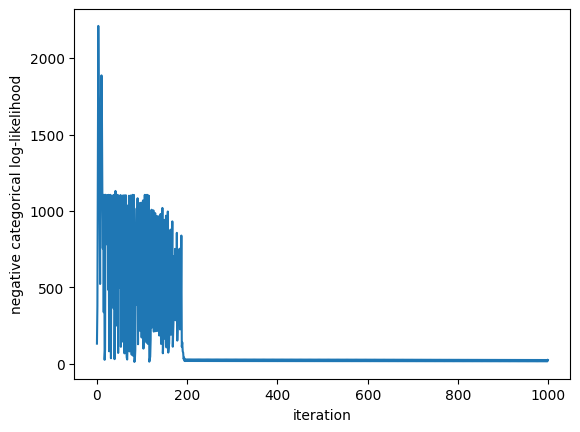

In [7]:

# optimization

w0_flat = np.zeros(5 * 3) # 4 features + bias, 3 classes
w_opt_flat, loss_opt, x_history, f_x_history = \
   minimize(lambda w: objective_cat(w, train_features, oh_train_labels),
            lambda w: d_objective_cat(w, train_features, oh_train_labels),
            w0_flat, 1e-2, 1000)

w_opt = np.reshape(w_opt_flat, [5, 3])

# plotting and evaluation
print("Final Loss:", loss_opt)
plt.figure()
plt.plot(f_x_history)
plt.xlabel("iteration")
plt.ylabel("negative categorical log-likelihood")

train_pred = softmax(train_features @ w_opt)
train_acc = np.count_nonzero(np.argmax(train_pred, axis=-1) == np.argmax(oh_train_labels, axis=-1))
train_acc /= train_labels.shape[0]
test_pred = softmax(test_features @ w_opt)
test_acc = np.count_nonzero(np.argmax(test_pred, axis=-1) == np.argmax(oh_test_labels, axis=-1))
test_acc /= test_labels.shape[0]
print("Train Accuracy:", train_acc, "Test Accuracy:", test_acc)

## 2.) Feature-Based Support Vector Machine (Hinge Loss) (5 Points)
In this exercise, we will train a feature-based SVM on the two moons dataset using the hinge loss. We will use the L-BFGS-B algorithm, provided by `scipy.optimize` for the optimization. All you need to know about this optimizer is that it is gradient-based. Otherwise, you can treat it as a black box. Yet, it's also worth a closer look if you are interested. To install scipy, use: **conda install -c conda-forge scikit-learn**

We load and visualize the data again. Note we change the label for class 0 to -1.

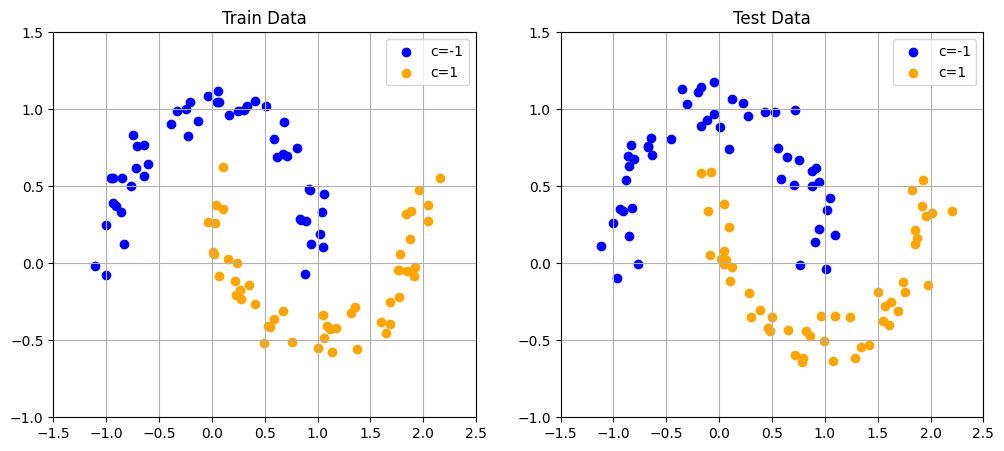

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## load data
train_data = dict(np.load("two_moons.npz", allow_pickle=True))
train_samples = train_data["samples"]
train_labels = train_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM
train_labels[train_labels == 0] = -1

test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
test_samples = test_data["samples"]
test_labels = test_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM
test_labels[test_labels == 0] = -1

## plot data
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Train Data")
plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")

plt.legend()
plt.subplot(1, 2, 2)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Test Data")
plt.scatter(x=test_samples[test_labels == -1, 0], y=test_samples[test_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=test_samples[test_labels == 1, 0], y=test_samples[test_labels == 1, 1], label="c=1", c="orange")

plt.legend()

For this exercise, we use cubic features $\phi(\boldsymbol x)$. Let us define a function to compute those features.

In [2]:
def cubic_feature_fn(samples: np.ndarray) -> np.ndarray:
    """
    :param x: Batch of 2D data vectors [x, y] [N x dim]
    :return cubic features: [x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, 1]
    """
    x = samples[..., 0]
    y = samples[..., 1]
    return np.stack([x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, np.ones(x.shape[0])], axis=-1)

### Exercise 2.1) Hinge Loss Objective (2 Points)

We will implement the hinge loss objective in this exercise. Its given by
 $$\mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(\boldsymbol w) = \parallel \boldsymbol{w} \parallel^2 + C \sum_i^N  \max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right),$$
 where $\boldsymbol{w}$ are our model parameters, $\phi(\boldsymbol{x})$ are our cubic features and the $y_i \in \lbrace{-1, 1\rbrace}$ are the class labels.

 The following function implements the hinge loss. Fill in the missing code snippets.

In [21]:
def objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> float:
    """
    objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape:[N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: factor to weigh the violation of margin with (C in slides)
    :returns svm (hinge) objective (shape: scalar)
    """
    ### TODO ###############################
    
    ########################################

    norm_sqr = np.linalg.norm(weights) ** 2

    margins = labels * (features @ weights)
    hinge_loss = np.maximum(0, 1 - margins)

    loss = norm_sqr + slack_regularizer * np.sum(hinge_loss)

    return loss

### Exercise 2.2) Hinge Loss Gradient (3 Points)
Derive and implement the gradient for the hinge loss objective stated above. For all non-differentiable points in the loss curves, you can use any valid subgradient.

**NOTE**: The derivation is explicitly part of this exercise, so state it in the file, not just implement it.


**Answer**

![](ex2.2.png)

In [22]:
def d_objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> np.ndarray:
    """
    gradient of objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape: [N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: factor to weigh the violation of margin with (C in slides)
    :returns gradient of svm objective (shape: [feature_dim])
    """
    ### TODO ###############################
    
    ########################################

    margins = labels * (features @ weights)

    violations = margins < 1

    gradient = 2 * weights - slack_regularizer * np.sum((labels[violations, np.newaxis] * features[violations]), axis=0)

    return gradient

### Train and Evaluate
Finally, we can tie everything together and get our maximum margin classifier. Here we are using the L-BFGS-B optimizer provided by Scipy. With $C=1000$ you should end up at a training accuracy of 1 and test accuracy of 0.99, but feel free to play around with $C$.

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 149.1125680841317
        x: [ 5.398e+00 -3.231e+00 -3.859e+00  4.361e+00 -7.785e+00
             4.754e-01  1.421e-01 -2.020e+00 -1.712e+00  2.785e+00]
      nit: 60
      jac: [ 1.080e+01 -6.463e+00 -7.718e+00  8.721e+00 -1.557e+01
             9.507e-01  2.842e-01 -4.039e+00 -3.424e+00  5.569e+00]
     nfev: 406
     njev: 406
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
Train Accuracy:  1.0
Test Accuracy:  0.99


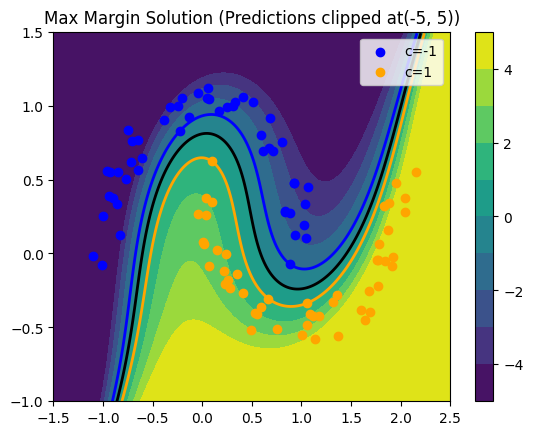

In [23]:
feature_fn = cubic_feature_fn
C = 1000.0

## optimization (for details cf. https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html)
train_features = feature_fn(train_samples)
res = opt.minimize(
    # pass objective
    fun=lambda w: objective_svm(w, train_features, train_labels, C),
    # pass initial point
    x0=np.ones(train_features.shape[-1]),
    # pass function to evaluate gradient (in scipy.opt "jac" for jacobian)
    jac=lambda w: d_objective_svm(w, train_features, train_labels, C),
    # specify method to use
    method="l-bfgs-b"
)
print(res)
w_svm = res.x

## evaluation
test_predictions = feature_fn(test_samples) @ w_svm
train_predictions = feature_fn(train_samples) @ w_svm

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))

## plot train, contour, decision boundary and margins
plt.figure()
plt.title("Max Margin Solution (Predictions clipped at(-5, 5))")
x_plt_range = np.arange(-1.5, 2.5, 0.01)
y_plt_range = np.arange(-1, 1.5, 0.01)
plt_grid = np.stack(np.meshgrid(x_plt_range, y_plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

pred_grid = np.reshape(feature_fn(flat_plt_grid) @ w_svm, plt_grid_shape)
pred_grid = np.clip(pred_grid, -5, 5)
#plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1.0, 0.0, 1.0], colors=["blue", "black", "orange"])
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
            linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)

plt.colorbar()

s0 =plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
s1 =plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

## 3) Kernel Ridge Regression (7p)

In this task, we are going to get familiar with the kernel method and perform Kernel Ridge Regression using Gaussian kernels.

Work flow:
- Load and plot data
- Implement a function to get the Gaussian kernel vector
- Implement a function to get the Gaussian kernel matrix
- Implement a function to apply Kernel Ridge Regression
- Select best model and see some result plots


### Load and plot data
First, let us load and plot our data. Note that in this example the test data is not corrupted by noise.


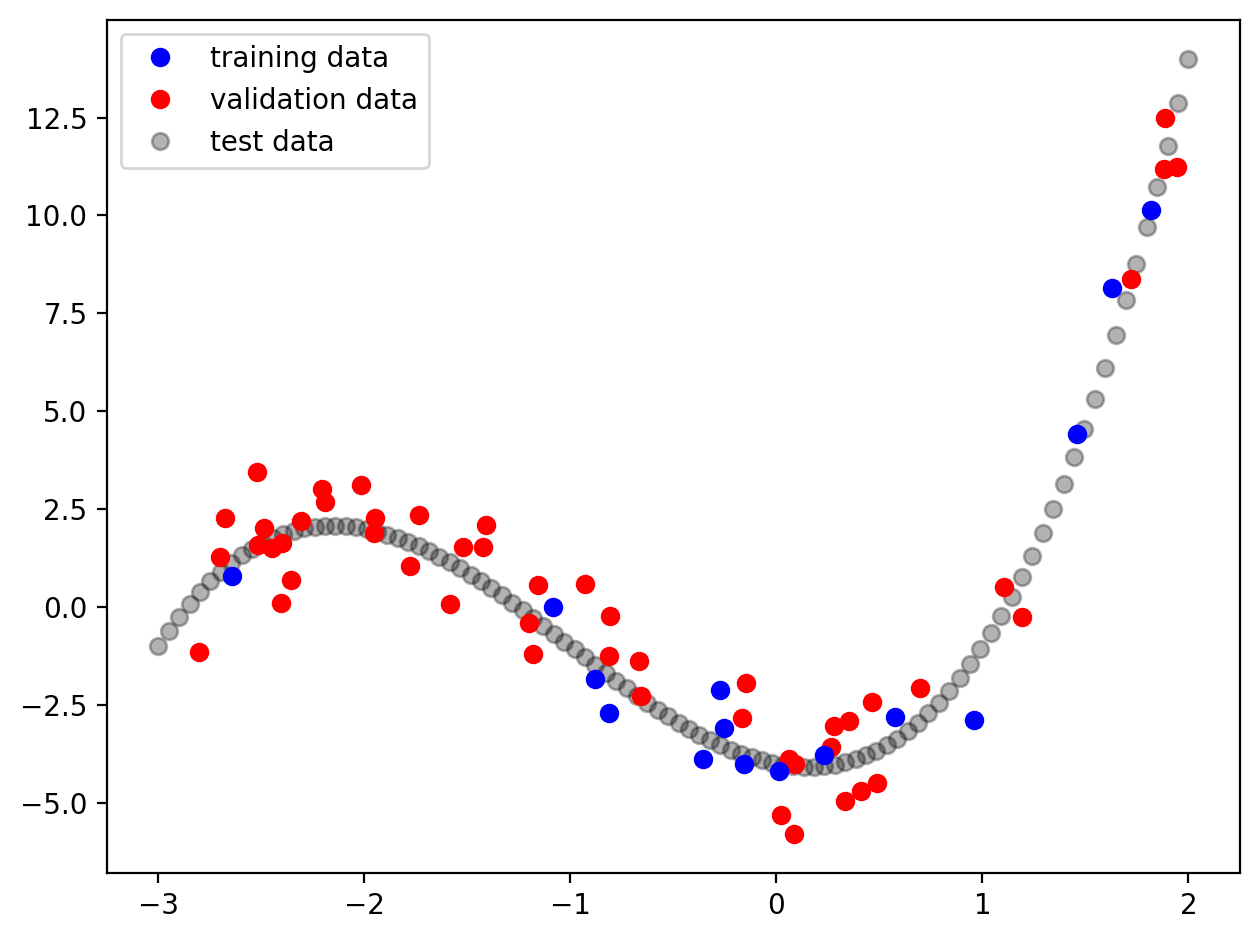

In [24]:


# Set random seed to obtain reproducible results
np.random.seed(0)

# Load training, validation and test datasets
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_valid = np.load('x_valid.npy')
y_valid = np.load('y_valid.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# Plot the data
plt.figure(dpi=200, tight_layout=True)
plt.plot(x_train, y_train, 'ob', label='training data', zorder=20)
plt.plot(x_valid, y_valid, 'or', label='validation data',zorder=10)
plt.plot(x_test, y_test, 'ok', label='test data', alpha=0.3, zorder=0)
plt.legend()
plt.show()


### 3.1 Training, Validation and Testing datasets (1pt)
In this homework, we are going to use a new type of dataset "validation" to help select our best hyperparameter and avoid overfitting. Please read the explanation below and understand the roles of training, validation and testing datasets respectively (1pt).

Training, validation, and test datasets are three distinct subsets of a larger dataset that are used in the process of building and evaluating machine learning models.

The training dataset is the subset of the data that is used to train a machine learning model. In other words, it's the data that the model learns from. Typically, the training dataset makes up the majority of the available data.

The validation dataset is used to evaluate the performance of a model during the training process. It's a subset of the data that is held back from the training process and used to tune the model's hyperparameters, such as learning rate, number of hidden layers, etc. The goal of the validation dataset is to help prevent overfitting, which is when the model memorizes the training data and performs poorly on new, unseen data.

The test dataset is a completely separate subset of the data that is used to evaluate the final performance of a trained model. It represents real-world data that the model has never seen before and is used to estimate the model's accuracy on new, unseen data. The test dataset should only be used after the model has been trained and validated to prevent any bias in the evaluation.

It's important to note that the three datasets should be independent and identically distributed (IID) to ensure that the model is able to generalize well to new data. In addition, the sizes of the datasets may vary depending on the size and complexity of the original dataset and the specific requirements of the machine learning problem at hand.

(Note: In our homework, however, we are going to use a large and denoised test dataset which is for plotting convienence.)

### Gaussian Kernels:
Since Gaussian kernels are the most commonly used kernels, we will concentrate on Gaussian kernels in this notebook. Remember the definition of a Gaussian kernel (slide 55):

\begin{align*}
    k(\boldsymbol{x}, \boldsymbol{x^*}) = \exp\left(-\frac{||\boldsymbol{x}-\boldsymbol{x^*}||^2}{2\sigma^2}\right),
\end{align*}

where $\boldsymbol{x}, \boldsymbol{x^*}$ are two $d$-dimensional data points. $ \sigma $ is the bandwidth hyperparameter. Recall that any kernel $k(\boldsymbol{x}, \boldsymbol{x^*})$ returns a scalar which represents some kind of discrepancy measure between two data points.



### 3.2 Kernel Vector (3pts)
Now we are going to implement a function to compute the kernel vector $\boldsymbol k(\boldsymbol x^*)$ (slide 59). Recall the definition: given $N$ training points $\boldsymbol{x_i}, i=1,...,N$, and one additional query point $\boldsymbol{x^*}$, $\boldsymbol{k(x^*)}$ is defined as the $N$-dimensional vector whose $i$-th element is given by the kernel, evaluated at training point $\boldsymbol{x_i}$ and the query point, i.e. $k(\boldsymbol{x_i, x^*})$.

Please finish the function below!

Hints:
- As we typically have $M > 1$ query points in practice, we would like to compute the corresponding $M$ kernel vectors in one function call, cf. the comments.
- The computations we have to perform are the same as in `gaussian_kernel()`. However, we are now operating on more than one input vectors at once.
- Avoid using loops! To this end, you may need to add additional dimensions to the input data and use broadcasting. Also, note that numpy operations such as `np.linalg.norm()` can operate on vector inputs and take an `axis`-argument!
- Make sure your code works also for data with dimension larger than 1. You are going to need this later.

In [25]:
def get_kernel_vec(X_t: np.ndarray,
                   X_q: np.ndarray,
                   sigma: float) -> np.ndarray:
    """
    :param X_t: N training inputs (shape: [N, d])
    :param X_q: M query inputs (shape: [M, d])
    :param sigma: bandwidth of the kernel (shape: scalar)
    :return: M kernel vectors arranged as the columns of a matrix with shape [N, M]
    """
    ############## Your code starts here ##############

    diff = X_t[:, None, :] - X_q[None, :, :]

    norm_sqr = np.linalg.norm(diff, axis=2)**2

    kernel_vectors = np.exp(-norm_sqr / (2 * sigma**2))

    ############### Your code ends here ###############

    # assert the output shape being [N, M]
    assert list(kernel_vectors.shape) == [X_t.shape[0], X_q.shape[0]]
    return kernel_vectors

### Radial Basis Function (RBF) features
Now we use `get_kernel_vec()` to compute the kernel vectors w.r.t. our training inputs, using the test inputs as the query points. This allows us to plot the RBF features: we observe that at each training data point a Gaussian bump (the Gaussian kernel) is centered and that the bandwith parameter specifies the width of each bump.

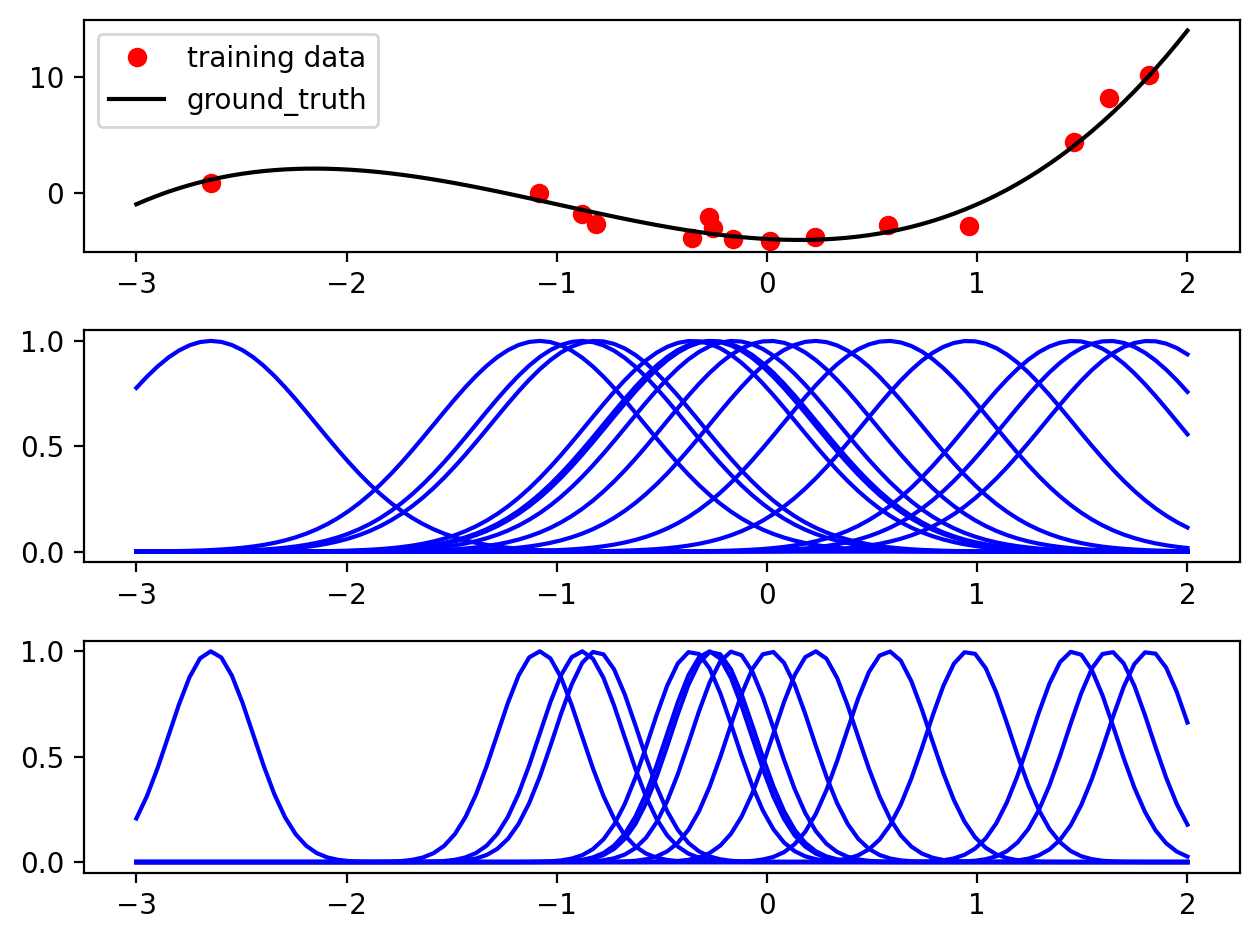

In [26]:
# Run this block to test your code

# Compute the kernel vectors w.r.t. the training inputs, using the test inputs as query points
kernel_vectors = get_kernel_vec(x_train, x_test, 0.5)
kernel_vectors2 = get_kernel_vec(x_train, x_test, 0.2)

# Prepare plot
plt.figure(dpi=200, tight_layout=True)

# Plot the data
plt.subplot(3,1,1)
plt.plot(x_train, y_train, 'ro')
plt.plot(x_test, y_test, 'k')
plt.legend(['training data', 'ground_truth'])

# Plot the kernel vectors
plt.subplot(3,1,2)
for kernel in kernel_vectors:
    plt.plot(x_test, kernel, 'b')

plt.subplot(3,1,3)
for kernel in kernel_vectors2:
    plt.plot(x_test, kernel, 'b')
plt.show()

### Kernel Ridge Regression with Gaussian Kernels

Let's go ahead and do regression using Gaussian kernels. Remember the regression equation (slide 67):

\begin{align*}
    f(\boldsymbol{x^*}) = \boldsymbol{k}(\boldsymbol{x^*})^T(\boldsymbol{K} + \lambda \boldsymbol{I})^{-1}\boldsymbol{y},
\end{align*}
where $ \boldsymbol{k}(\boldsymbol{x^*}) $ is the kernel vector, $ \boldsymbol{K}$ is the kernel matrix and $ \boldsymbol{y} $ are the target values from the training data.

### 3.3 Kernel Matrix (1pt)
First, we have to compute the kernel matrix $\boldsymbol K$ (slide 59). Recall the definition: $[\boldsymbol K]_{ij} = k(\boldsymbol x_i, \boldsymbol x_j)$ with our training inputs $\boldsymbol{x_i}, i=1,...,N$.

Implement the function below (hint: re-use the `get_kernel_vec()` function)!

In [27]:
def get_kernel_mat(X: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X: N training inputs (shape [N, d])
    :sigma: bandwidth of the kernel (scalar)
    :return: the kernel matrix (shape [N, N])
    """
    ############## Your code starts here ##############

    kernel_mat = get_kernel_vec(X, X, sigma)

    ############### Your code ends here ###############
    # assert the output shape being [N, N]
    assert list(kernel_mat.shape) == [X.shape[0], X.shape[0]]
    return kernel_mat

### 3.4 Kernel Regression Prediction (2pts)
Now that we have finished the implementation of the kernel vector $\boldsymbol{k(x^*)}$ and the kernel matrix $\boldsymbol{K}$, we can compute the prediction $f(\boldsymbol{x^*})$ in the function in below. Here we choose a fixed ridge factor $ \lambda = 10^{-3}$.

Hint: make sure you use numerically stable operations!


In [31]:
def predict(X_t: np.ndarray, y_t: np.ndarray,
            X_q: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X_t: N training inputs (shape [N, d])
    :param y_t: N training targets (shape [N, 1])
    :param X_q: M query inputs (shape [M, d])
    :param sigma: bandwidth of the kernel (scalar)
    :return: predicted values at X_q (shape [M, 1])
    """
    k = get_kernel_vec(X_t, X_q, sigma) # shape [N, M]
    K = get_kernel_mat(X_t, sigma) # shape [N, N]
    ridge_factor = 1e-3
    ############## Your code starts here ##############

    A = K + ridge_factor * np.identity(K.shape[0])

    alpha = np.linalg.solve(A, y_t)

    prediction = k.T @ alpha

    ############### Your code ends here ###############
    return prediction

### Mean Squared Error
Once again, we will use the mean squared error to measure the training and test error:

In [ ]:
def mse(y_target: np.ndarray, y_pred: np.ndarray) -> float:
    """
    :param y_target: true y values
    :param y_pred: predicted y values
    :return: MSE
    """
    return np.sum((y_target-y_pred)**2)/y_pred.shape[0]

### Model selection
The Gaussian kernel method introduces a hyperparameter (the bandwidth $\sigma$). We have to determine its value via model selection. Here, we use the hold-out method, i.e., we try different $\sigma$ values and select the model which performs best on the validation dataset.

minimum validation error for sigma = 3.00


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3977/3042992199.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel( "$\sigma$")


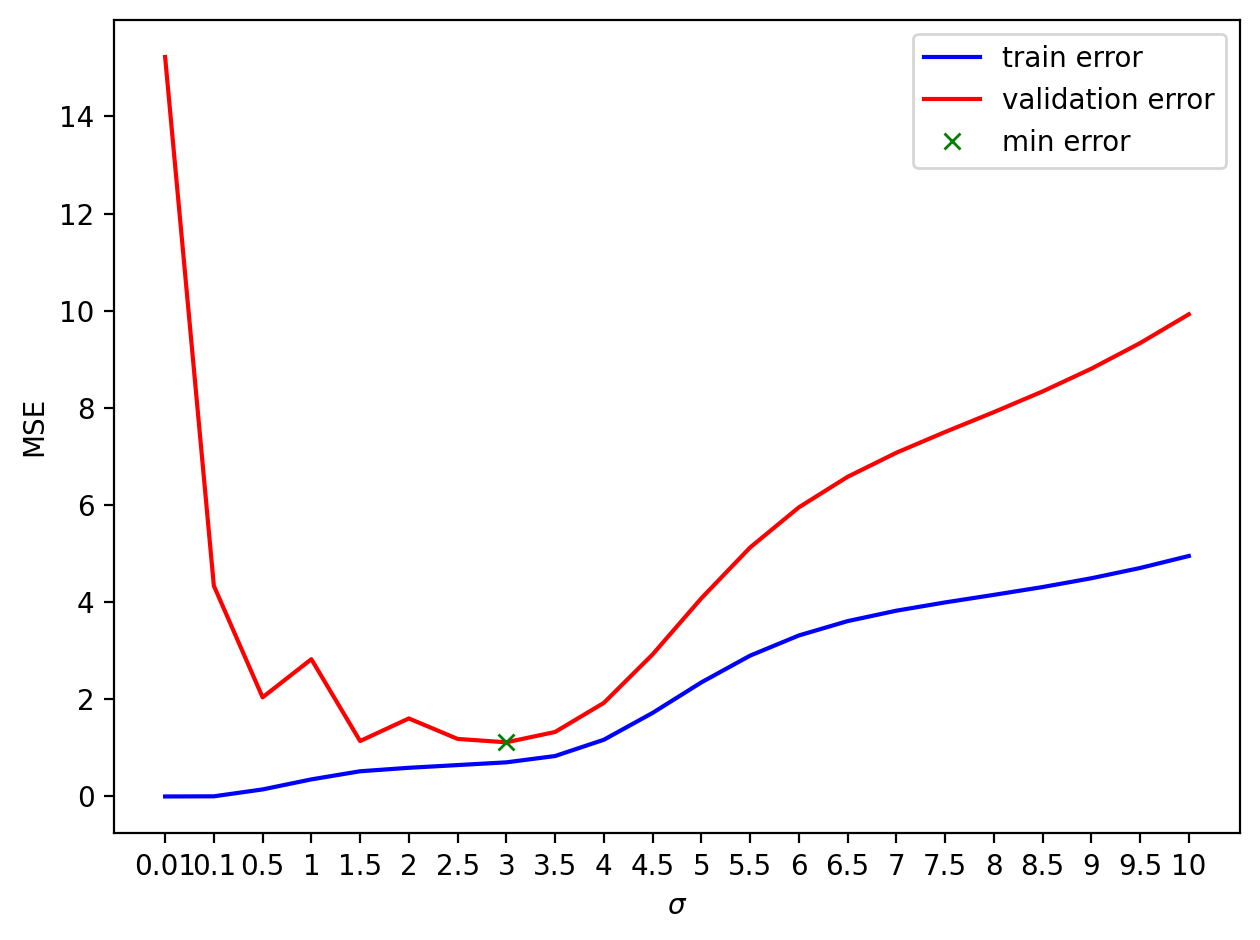

In [33]:
sigmas = [0.01, .1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

# compute train and validation errors for the different sigma values
train_errors = []
validate_errors = []
for sigma in sigmas:
    predict_train = predict(X_t=x_train, y_t=y_train,
                              X_q=x_train, sigma=sigma)
    predict_valid = predict(X_t=x_train, y_t=y_train,
                             X_q=x_valid, sigma=sigma)
    train_errors.append(mse(y_train, predict_train))
    validate_errors.append(mse(y_valid, predict_valid))

# determine best model
min_valid_error_index = validate_errors.index(min(validate_errors))
print(f'minimum validation error for sigma = {sigmas[min_valid_error_index]:.2f}')

# plot the errors
x_axis = [str(x) for x in sigmas]
error_plot = plt.figure(dpi=200, tight_layout=True)
plt.plot(x_axis, train_errors, 'b')
plt.plot(x_axis, validate_errors, 'r')
plt.plot(x_axis[min_valid_error_index], validate_errors[min_valid_error_index], 'gx')
plt.xlabel( "$\sigma$")
plt.ylabel( "MSE" )
plt.legend(['train error', 'validation error','min error'])

We again observe the typical behavior: we have clear overfitting for small $ \sigma $ values (high model complexity). For high $ \sigma $ values (low model complexity) we observe underfitting. The best performing model is marked with a green 'x', as the minimum validation error is achieved for $ \sigma = 3 $.

Let's look at predictions for different $ \sigma $ values.

sigma = 5.00
MSE train: 2.35
MSE valid: 4.08
MSE test : 2.91


<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3977/2515485147.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(['Training data', 'Ground-truth', '$\sigma$ =' + str(sigma)])


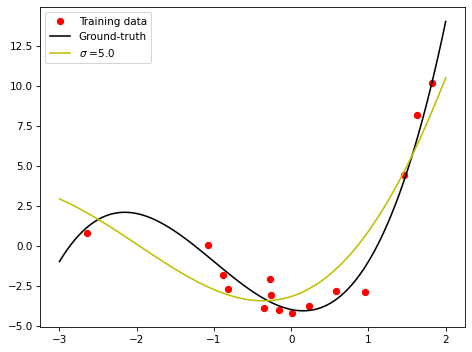

sigma = 3.00
MSE train: 0.70
MSE valid: 1.11
MSE test : 0.12


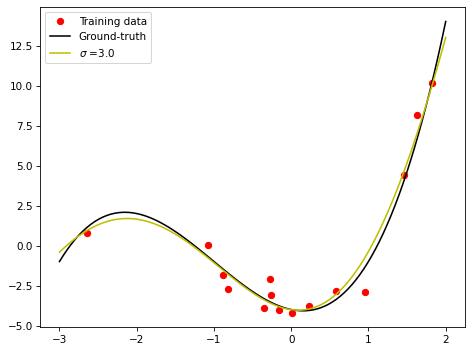

sigma = 1.00
MSE train: 0.35
MSE valid: 2.83
MSE test : 1.94


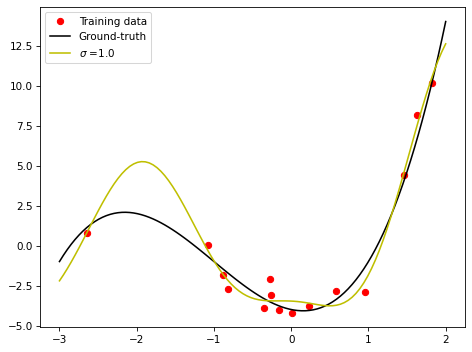

sigma = 0.10
MSE train: 0.00
MSE valid: 4.34
MSE test : 4.28


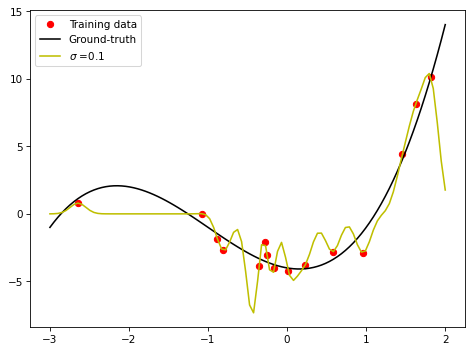

In [34]:
# plot predictions for various bandwith parameters
for sigma in [5.0,  3.0, 1.0 , 0.1]:
    # compute predictions on train, test, and validation sets
    y_pred_train = predict(X_t=x_train, y_t=y_train, X_q=x_train, sigma=sigma)
    y_pred_valid = predict(X_t=x_train, y_t=y_train, X_q=x_valid, sigma=sigma)
    y_pred_test = predict(X_t=x_train, y_t=y_train, X_q=x_test, sigma=sigma)

    # print MSEs
    print(f'sigma = {sigma:.2f}')
    print(f'MSE train: {mse(y_train, y_pred_train):.2f}')
    print(f'MSE valid: {mse(y_valid, y_pred_valid):.2f}')
    print(f'MSE test : {mse(y_test, y_pred_test):.2f}')

    # plot predictions
    sigma_fig = plt.figure(dpi=75, tight_layout=True)
    plt.plot(x_train, y_train, 'ro')
    plt.plot(x_test, y_test, 'k')
    plt.plot(x_test, y_pred_test, 'y')
    plt.legend(['Training data', 'Ground-truth', '$\sigma$ =' + str(sigma)])
    plt.show()

We again observe that the model overfits for $ \sigma < 3.0 $ and underfits for $\sigma > 3.0$, with $\sigma = 3.0$ achieving the minimum validation error.

Note that the model prediction reverts back to $0$ far away from training data (where "far away" has to be understood relative to the bandwidth $\sigma$). E.g., for $ \sigma = 0.1 $, the model prediction reverts back to $0$ in the input region [-2.5, -1.5] as all training points are "far away" w.r.t. the small bandwith value.